In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
import pandas as pd
from sklearn.neighbors import DistanceMetric
from math import radians

<font size = 5>Rebuild the following model from Wu et al. 2002</font>

![wu_model1](https://i.imgur.com/KdwHvTk.png)

![wu_model2](https://i.imgur.com/h6Dng6i.png)

In [2]:
# Start of with constructing the set of all potential DC sites = I
# Start with only 1 possible DC=DEPOT

#create an index
DC_ID = ["DC_1"] #, 2, 3, 4]

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [20] # 20, 20, 20]

#Maximum Throughput at depot i = Vi
capacity_DC = [50] # 50, 50, 50]

#Position of the DCs
lat_DC = [49.794783]# 49.81613668, 49.78379436, 49.74101263]
lon_DC = [9.906499]# 9.897654496, 9.896245726, 9.88898842]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, lat_DC, lon_DC))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "lat_DC", "lon_DC"])
set_of_all_DC.set_index("DC_ID", inplace = True)
set_of_all_DC

,fixed_cost_DC,capacity_DC,lat_DC,lon_DC
DC_ID,,,,
DC_1,20,50,49.794783,9.906499


In [3]:
# Define I
I = set_of_all_DC.index.values
I

array(['DC_1'], dtype=object)

In [4]:
# Construct set of all potential Customers J

# create index
C_ID = ["C1", "C2", "C3", "C4", "C5"]

# Set the demand dj
demand_C = [5, 5, 5, 5, 5]

# Position of customers
lat_C = [49.78981985, 49.79961774, 49.75060158, 49.79996773, 49.76905279]
lon_C = [9.964805881, 9.873297251, 9.919076627, 9.889586523, 9.913514194]

c_tuples = list(zip(C_ID, demand_C, lat_C, lon_C))

set_of_all_customers = pd.DataFrame(c_tuples, columns = ["C_ID", "demand_C", "lat_C", "lon_C"])
set_of_all_customers.set_index("C_ID", inplace = True)
set_of_all_customers

,demand_C,lat_C,lon_C
C_ID,,,
C1,5,49.789820,9.964806
C2,5,49.799618,9.873297
C3,5,49.750602,9.919077
C4,5,49.799968,9.889587
C5,5,49.769053,9.913514


In [5]:
J = set_of_all_customers.index.values
J

array(['C1', 'C2', 'C3', 'C4', 'C5'], dtype=object)

In [6]:
# Construct set of all vehicles K

# create index
V_ID = ["V_1","V_2"]

# Vehicle Capacity Qk
capacity_V = [15,15]

# fixed cost of using Vehicle Fk
fixed_cost_V = [5,5]

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,15,5
V_2,15,5


In [7]:
K = set_of_all_vehicles.index.values
K

array(['V_1', 'V_2'], dtype=object)

<font size = 5>**Somehow have to create a distance matrix between points i and j. This would be the parameter Cij**</font>

In [8]:
#Set up a DF for the distance matrix
data = {"C_ID": ["DC_1", # Depot
                "C1","C2","C3","C4","C5"], # Customers
         "lat": [49.794783, #Depot
                 49.78981985, 49.79961774, 49.75060158, 49.79996773, 49.76905279], #Customers
         "lon": [9.906499, #Depot
                 9.964805881, 9.873297251, 9.919076627, 9.889586523, 9.913514194]} #Customers

In [9]:
DF = pd.DataFrame(data, columns = ["C_ID", "lat", "lon"])
DF


,C_ID,lat,lon
0,DC_1,49.794783,9.906499
1,C1,49.789820,9.964806
2,C2,49.799618,9.873297
3,C3,49.750602,9.919077
4,C4,49.799968,9.889587
5,C5,49.769053,9.913514


In [10]:
DF['lat'] = np.radians(DF['lat'])
DF['lon'] = np.radians(DF['lon'])
DF

,C_ID,lat,lon
0,DC_1,0.869083,0.172901
1,C1,0.868996,0.173919
2,C2,0.869167,0.172322
3,C3,0.868312,0.173121
4,C4,0.869173,0.172606
5,C5,0.868634,0.173023


In [11]:
dist = DistanceMetric.get_metric("haversine")

In [12]:
DF[["lat", "lon"]].to_numpy()

array([[0.86908291, 0.17290102],
       [0.86899629, 0.17391867],
       [0.8691673 , 0.17232155],
       [0.8683118 , 0.17312055],
       [0.8691734 , 0.17260585],
       [0.86863384, 0.17302346]])

In [13]:
#Create the dist matrix in meters
dist_matrix = pd.DataFrame(dist.pairwise(DF[["lat", "lon"]].to_numpy())*6378100, columns=DF.C_ID.unique(), index=DF.C_ID.unique())
dist_matrix.round(1)

,DC_1,C1,C2,C3,C4,C5
DC_1,0.0,4226.4,2445.7,5000.7,1345.3,2908.3
C1,4226.4,0.0,6665.6,5465.2,5522.0,4351.8
C2,2445.7,6665.6,0.0,6372.1,1171.1,4464.5
C3,5000.7,5465.2,6372.1,0.0,5890.1,2092.6
C4,1345.3,5522.0,1171.1,5890.1,0.0,3847.2
C5,2908.3,4351.8,4464.5,2092.6,3847.2,0.0


In [14]:
print(dist_matrix.dtypes)

DC_1    float64
C1      float64
C2      float64
C3      float64
C4      float64
C5      float64
dtype: object


In [15]:
#Convert to integers for further handling
dist_mat1 = dist_matrix.astype(int)
dist_mat1

,DC_1,C1,C2,C3,C4,C5
DC_1,0,4226,2445,5000,1345,2908
C1,4226,0,6665,5465,5521,4351
C2,2445,6665,0,6372,1171,4464
C3,5000,5465,6372,0,5890,2092
C4,1345,5521,1171,5890,0,3847
C5,2908,4351,4464,2092,3847,0


In [16]:
# Helper Index

R1 = [(i,j,k) for i in J for j in J if i != j for k in K]
R2 = [(i,j,k) for i in I for j in J if i!=j for k in K]
R3 = [(j,i,k) for j in J for i in I if i!=j for k in K]
R1 += R2
R1 += R3

In [17]:
df3 = pd.DataFrame(R1, columns = ["start", "end","vehicle"])
df3.set_index(["start","end", "vehicle"], inplace=True)
df3.tail(10)

Empty DataFrame
Columns: []
Index: [(C1, DC_1, V_1), (C1, DC_1, V_2), (C2, DC_1, V_1), (C2, DC_1, V_2), (C3, DC_1, V_1), (C3, DC_1, V_2), (C4, DC_1, V_1), (C4, DC_1, V_2), (C5, DC_1, V_1), (C5, DC_1, V_2)]

In [18]:
# Add distances manually, dont know how to do this better
distances_routes2 = [6665.6, 6665.6, 5465.2, 5465.2, 5522.0, 5522.0,4351.8,4351.8,
                    6665.6, 6665.6, 6372.1, 6372.1,	1171.1,1171.1,	4464.5, 4464.5,
                    5465.2, 5465.2,	6372.1, 6372.1, 5890.1, 5890.1,	2092.6, 2092.6,
                    5522.0, 5522.0,	1171.1, 1171.1,	5890.1, 5890.1, 3847.2, 3847.2,
                    4351.8, 4351.8,	4464.5, 4464.5,	2092.6, 2092.6,	3847.2, 3847.2,
                    4226.4, 4226.4,	2445.7, 2445.7,	5000.7, 5000.7,	1345.3, 1345.3,	2908.3, 2908.3,
                    4226.4, 4226.4, 2445.7, 2445.7,	5000.7, 5000.7,	1345.3, 1345.3,	2908.3, 2908.3]
df3["Distance"] = distances_routes2
R_df = df3
R_df.head()

Distance
start end vehicle          
C1    C2  V_1        6665.6
          V_2        6665.6
      C3  V_1        5465.2
          V_2        5465.2
      C4  V_1        5522.0

In [19]:
# R can be used as a helper index
R = R_df.index.values
R

array([('C1', 'C2', 'V_1'), ('C1', 'C2', 'V_2'), ('C1', 'C3', 'V_1'),
       ('C1', 'C3', 'V_2'), ('C1', 'C4', 'V_1'), ('C1', 'C4', 'V_2'),
       ('C1', 'C5', 'V_1'), ('C1', 'C5', 'V_2'), ('C2', 'C1', 'V_1'),
       ('C2', 'C1', 'V_2'), ('C2', 'C3', 'V_1'), ('C2', 'C3', 'V_2'),
       ('C2', 'C4', 'V_1'), ('C2', 'C4', 'V_2'), ('C2', 'C5', 'V_1'),
       ('C2', 'C5', 'V_2'), ('C3', 'C1', 'V_1'), ('C3', 'C1', 'V_2'),
       ('C3', 'C2', 'V_1'), ('C3', 'C2', 'V_2'), ('C3', 'C4', 'V_1'),
       ('C3', 'C4', 'V_2'), ('C3', 'C5', 'V_1'), ('C3', 'C5', 'V_2'),
       ('C4', 'C1', 'V_1'), ('C4', 'C1', 'V_2'), ('C4', 'C2', 'V_1'),
       ('C4', 'C2', 'V_2'), ('C4', 'C3', 'V_1'), ('C4', 'C3', 'V_2'),
       ('C4', 'C5', 'V_1'), ('C4', 'C5', 'V_2'), ('C5', 'C1', 'V_1'),
       ('C5', 'C1', 'V_2'), ('C5', 'C2', 'V_1'), ('C5', 'C2', 'V_2'),
       ('C5', 'C3', 'V_1'), ('C5', 'C3', 'V_2'), ('C5', 'C4', 'V_1'),
       ('C5', 'C4', 'V_2'), ('DC_1', 'C1', 'V_1'), ('DC_1', 'C1', 'V_2'),
       ('DC_1', 

<font size="6">**Objective Function for Wu Model**</font><br>
![wu3](https://i.imgur.com/4XTRhD4.png)


In [20]:
model = LpProblem("LRP", LpMinimize)

![wu_model2](https://i.imgur.com/h6Dng6i.png)

<font size = 5>**Declare Decision Variables**</font>

In [21]:
# Define every combination of possible points for every vehicle? 
# New way of defining X produces a different Form of variable. x_DC1_C1_V_1 instead of x_("DC1",_"C1",_"V_1")
#x = LpVariable.dicts(name = "x", indexs=R, lowBound = 0, upBound = 1, cat = "Binary")
#x = LpVariable.dicts(name = "x", indexs=wi, cat = "Binary")
x = LpVariable.dicts(name = "x", indexs=([*I,*J],[*I,*J],K), cat = "Binary")
x

{'DC_1': {'DC_1': {'V_1': x_DC_1_DC_1_V_1, 'V_2': x_DC_1_DC_1_V_2},
  'C1': {'V_1': x_DC_1_C1_V_1, 'V_2': x_DC_1_C1_V_2},
  'C2': {'V_1': x_DC_1_C2_V_1, 'V_2': x_DC_1_C2_V_2},
  'C3': {'V_1': x_DC_1_C3_V_1, 'V_2': x_DC_1_C3_V_2},
  'C4': {'V_1': x_DC_1_C4_V_1, 'V_2': x_DC_1_C4_V_2},
  'C5': {'V_1': x_DC_1_C5_V_1, 'V_2': x_DC_1_C5_V_2}},
 'C1': {'DC_1': {'V_1': x_C1_DC_1_V_1, 'V_2': x_C1_DC_1_V_2},
  'C1': {'V_1': x_C1_C1_V_1, 'V_2': x_C1_C1_V_2},
  'C2': {'V_1': x_C1_C2_V_1, 'V_2': x_C1_C2_V_2},
  'C3': {'V_1': x_C1_C3_V_1, 'V_2': x_C1_C3_V_2},
  'C4': {'V_1': x_C1_C4_V_1, 'V_2': x_C1_C4_V_2},
  'C5': {'V_1': x_C1_C5_V_1, 'V_2': x_C1_C5_V_2}},
 'C2': {'DC_1': {'V_1': x_C2_DC_1_V_1, 'V_2': x_C2_DC_1_V_2},
  'C1': {'V_1': x_C2_C1_V_1, 'V_2': x_C2_C1_V_2},
  'C2': {'V_1': x_C2_C2_V_1, 'V_2': x_C2_C2_V_2},
  'C3': {'V_1': x_C2_C3_V_1, 'V_2': x_C2_C3_V_2},
  'C4': {'V_1': x_C2_C4_V_1, 'V_2': x_C2_C4_V_2},
  'C5': {'V_1': x_C2_C5_V_1, 'V_2': x_C2_C5_V_2}},
 'C3': {'DC_1': {'V_1': x_C3_DC_1_V

In [22]:
# yi indicating if depot i is opened or not
y = LpVariable.dicts(name = "y", indexs=I, lowBound = 0, upBound = 1, cat = "Binary")
y

{'DC_1': y_DC_1}

In [23]:
# zij indicating if customer j is allocated to depot i 
#H = [(i,j) for i in I for j in J]
#z = LpVariable.dicts(name = "z", indexs = H, cat = "Binary")
#z

In [24]:
# Try new Z form to see if it fixes the problem (Could also be a problem with constraints 7 or 8)

z = LpVariable.dicts(name = "z", indexs = (I,J), cat = "Binary")
z

{'DC_1': {'C1': z_DC_1_C1,
  'C2': z_DC_1_C2,
  'C3': z_DC_1_C3,
  'C4': z_DC_1_C4,
  'C5': z_DC_1_C5}}

In [25]:
# Auxiliary Sub-Tour Elimination Variable Ulk
U = [(l,k) for l in J for k in K]
u = LpVariable.dicts(name = "u", indexs = U, lowBound = 0, cat = "Continuous")
u

{('C1', 'V_1'): u_('C1',_'V_1'),
 ('C1', 'V_2'): u_('C1',_'V_2'),
 ('C2', 'V_1'): u_('C2',_'V_1'),
 ('C2', 'V_2'): u_('C2',_'V_2'),
 ('C3', 'V_1'): u_('C3',_'V_1'),
 ('C3', 'V_2'): u_('C3',_'V_2'),
 ('C4', 'V_1'): u_('C4',_'V_1'),
 ('C4', 'V_2'): u_('C4',_'V_2'),
 ('C5', 'V_1'): u_('C5',_'V_1'),
 ('C5', 'V_2'): u_('C5',_'V_2')}

In [26]:
# Objective Function 
# Gi * yi
fixedCost_depot = lpSum([y[i] * set_of_all_DC.loc[i].fixed_cost_DC for i in I])

#Cij * Xijk
#This worked after I used the dist_mat1 with integers instead of floats
variableCosts = lpSum([[x[i][j][k]] * dist_mat1.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

#Fk * Xijk

fixedCost_vehicle = lpSum([[x[i][j][k]] * set_of_all_vehicles.loc[k].fixed_cost_V  for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

In [27]:
variableCosts

6665*x_C1_C2_V_1 + 6665*x_C1_C2_V_2 + 5465*x_C1_C3_V_1 + 5465*x_C1_C3_V_2 + 5521*x_C1_C4_V_1 + 5521*x_C1_C4_V_2 + 4351*x_C1_C5_V_1 + 4351*x_C1_C5_V_2 + 4226*x_C1_DC_1_V_1 + 4226*x_C1_DC_1_V_2 + 6665*x_C2_C1_V_1 + 6665*x_C2_C1_V_2 + 6372*x_C2_C3_V_1 + 6372*x_C2_C3_V_2 + 1171*x_C2_C4_V_1 + 1171*x_C2_C4_V_2 + 4464*x_C2_C5_V_1 + 4464*x_C2_C5_V_2 + 2445*x_C2_DC_1_V_1 + 2445*x_C2_DC_1_V_2 + 5465*x_C3_C1_V_1 + 5465*x_C3_C1_V_2 + 6372*x_C3_C2_V_1 + 6372*x_C3_C2_V_2 + 5890*x_C3_C4_V_1 + 5890*x_C3_C4_V_2 + 2092*x_C3_C5_V_1 + 2092*x_C3_C5_V_2 + 5000*x_C3_DC_1_V_1 + 5000*x_C3_DC_1_V_2 + 5521*x_C4_C1_V_1 + 5521*x_C4_C1_V_2 + 1171*x_C4_C2_V_1 + 1171*x_C4_C2_V_2 + 5890*x_C4_C3_V_1 + 5890*x_C4_C3_V_2 + 3847*x_C4_C5_V_1 + 3847*x_C4_C5_V_2 + 1345*x_C4_DC_1_V_1 + 1345*x_C4_DC_1_V_2 + 4351*x_C5_C1_V_1 + 4351*x_C5_C1_V_2 + 4464*x_C5_C2_V_1 + 4464*x_C5_C2_V_2 + 2092*x_C5_C3_V_1 + 2092*x_C5_C3_V_2 + 3847*x_C5_C4_V_1 + 3847*x_C5_C4_V_2 + 2908*x_C5_DC_1_V_1 + 2908*x_C5_DC_1_V_2 + 4226*x_DC_1_C1_V_1 + 4226*x_DC

In [28]:
fixedCost_vehicle

5*x_C1_C2_V_1 + 5*x_C1_C2_V_2 + 5*x_C1_C3_V_1 + 5*x_C1_C3_V_2 + 5*x_C1_C4_V_1 + 5*x_C1_C4_V_2 + 5*x_C1_C5_V_1 + 5*x_C1_C5_V_2 + 5*x_C1_DC_1_V_1 + 5*x_C1_DC_1_V_2 + 5*x_C2_C1_V_1 + 5*x_C2_C1_V_2 + 5*x_C2_C3_V_1 + 5*x_C2_C3_V_2 + 5*x_C2_C4_V_1 + 5*x_C2_C4_V_2 + 5*x_C2_C5_V_1 + 5*x_C2_C5_V_2 + 5*x_C2_DC_1_V_1 + 5*x_C2_DC_1_V_2 + 5*x_C3_C1_V_1 + 5*x_C3_C1_V_2 + 5*x_C3_C2_V_1 + 5*x_C3_C2_V_2 + 5*x_C3_C4_V_1 + 5*x_C3_C4_V_2 + 5*x_C3_C5_V_1 + 5*x_C3_C5_V_2 + 5*x_C3_DC_1_V_1 + 5*x_C3_DC_1_V_2 + 5*x_C4_C1_V_1 + 5*x_C4_C1_V_2 + 5*x_C4_C2_V_1 + 5*x_C4_C2_V_2 + 5*x_C4_C3_V_1 + 5*x_C4_C3_V_2 + 5*x_C4_C5_V_1 + 5*x_C4_C5_V_2 + 5*x_C4_DC_1_V_1 + 5*x_C4_DC_1_V_2 + 5*x_C5_C1_V_1 + 5*x_C5_C1_V_2 + 5*x_C5_C2_V_1 + 5*x_C5_C2_V_2 + 5*x_C5_C3_V_1 + 5*x_C5_C3_V_2 + 5*x_C5_C4_V_1 + 5*x_C5_C4_V_2 + 5*x_C5_DC_1_V_1 + 5*x_C5_DC_1_V_2 + 5*x_DC_1_C1_V_1 + 5*x_DC_1_C1_V_2 + 5*x_DC_1_C2_V_1 + 5*x_DC_1_C2_V_2 + 5*x_DC_1_C3_V_1 + 5*x_DC_1_C3_V_2 + 5*x_DC_1_C4_V_1 + 5*x_DC_1_C4_V_2 + 5*x_DC_1_C5_V_1 + 5*x_DC_1_C5_V_2 + 

In [29]:
fixedCost_depot

20.0*y_DC_1 + 0.0

In [30]:
model += fixedCost_depot + variableCosts + fixedCost_vehicle

<font size="6"> **Constraints**</font>

![wu_constraints](https://i.imgur.com/Rwjsrnx.png)

(2) Each customer has to be assigned to a single route <br>
(3) Capacity constraint for the vehicle<br>
(4) New subtour elimination constraint<br>
(5) Flow conservation constraint<br>
(6) Each Route can only be served once<br>
(7) Capacity Constraint for DC<br>
(8) Specifies that a customer can only be assigned to a DC if there is a route from that DC going through that customer<br>
(9-11) Binary Requirements for decision variables - guess this was done by defining them as binary in pulp? <br>
(12) Ulks auxiliary variable can only take positive values

In [31]:
# (2) new
for j in J:
    model += lpSum([[x[i][j][k]] for i in [*I,*J] for k in K if i!=j]) == 1

In [32]:
# (3) new
for k in K:
    model += lpSum([set_of_all_customers.loc[j].demand_C * x[i][j][k] for i in [*I,*J] for j in J if i!=j]) <= set_of_all_vehicles.loc[k].capacity_V

In [33]:
# (4) new
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                model += (u[l,k] - u[j,k] + (len(set_of_all_customers) * [x[l][j][k]])) <= len(set_of_all_customers) - 1

In [34]:
# (5) new
for i in [*I,*J]:
    for k in K:
        model+= lpSum([[x[i][j][k]] for j in [*I,*J] if i!=j]) - lpSum([[x[j][i][k]] for j in [*I,*J] if i!=j]) == 0

In [35]:
# (6) new
for k in K:
    model += lpSum([[x[i][j][k]] for i in I for j in J]) <= 1

In [36]:
# (7) new -

for i in I:
    model += lpSum(z[i][j] * set_of_all_customers.loc[j].demand_C for j in J) - (set_of_all_DC.loc[i].capacity_DC * y[i]) <= 0

In [37]:
# (8) new: when removing the u!=i and u!=j the Z Variable seems to function correctly
# Dont understand what is happening here
for i in I:
    for j in J:
        for k in K:
            model += lpSum([x[i][u][k] + x[u][j][k] for u in [*I,*J]]) - z[i][j] <= 1

<font size="6"> **Model Solver and Solution Printer**</font>

In [38]:
model.solve(GUROBI_CMD())
LpStatus[model.status]

'Optimal'

In [39]:
for variable in model.variables():
    print("{} = {}".format(variable.name, variable.varValue))

u_('C1',_'V_1') = 0.0
u_('C1',_'V_2') = 2.0
u_('C2',_'V_1') = 0.0
u_('C2',_'V_2') = 0.0
u_('C3',_'V_1') = 0.0
u_('C3',_'V_2') = 1.0
u_('C4',_'V_1') = 1.0
u_('C4',_'V_2') = 0.0
u_('C5',_'V_1') = 0.0
u_('C5',_'V_2') = 0.0
x_C1_C1_V_1 = 0.0
x_C1_C1_V_2 = 0.0
x_C1_C2_V_1 = 0.0
x_C1_C2_V_2 = 0.0
x_C1_C3_V_1 = 0.0
x_C1_C3_V_2 = 0.0
x_C1_C4_V_1 = 0.0
x_C1_C4_V_2 = 0.0
x_C1_C5_V_1 = 0.0
x_C1_C5_V_2 = 0.0
x_C1_DC_1_V_1 = 0.0
x_C1_DC_1_V_2 = 1.0
x_C2_C1_V_1 = 0.0
x_C2_C1_V_2 = 0.0
x_C2_C2_V_1 = 0.0
x_C2_C2_V_2 = 0.0
x_C2_C3_V_1 = 0.0
x_C2_C3_V_2 = 0.0
x_C2_C4_V_1 = 1.0
x_C2_C4_V_2 = 0.0
x_C2_C5_V_1 = 0.0
x_C2_C5_V_2 = 0.0
x_C2_DC_1_V_1 = 0.0
x_C2_DC_1_V_2 = 0.0
x_C3_C1_V_1 = 0.0
x_C3_C1_V_2 = 1.0
x_C3_C2_V_1 = 0.0
x_C3_C2_V_2 = 0.0
x_C3_C3_V_1 = 0.0
x_C3_C3_V_2 = 0.0
x_C3_C4_V_1 = 0.0
x_C3_C4_V_2 = 0.0
x_C3_C5_V_1 = 0.0
x_C3_C5_V_2 = 0.0
x_C3_DC_1_V_1 = 0.0
x_C3_DC_1_V_2 = 0.0
x_C4_C1_V_1 = 0.0
x_C4_C1_V_2 = 0.0
x_C4_C2_V_1 = 0.0
x_C4_C2_V_2 = 0.0
x_C4_C3_V_1 = 0.0
x_C4_C3_V_2 = 0.0
x_C4_C4_V_1 

In [40]:
for variable in model.variables():
    if variable.varValue >= 0.1:
        print("{} = {}".format(variable.name, variable.varValue))

u_('C1',_'V_2') = 2.0
u_('C3',_'V_2') = 1.0
u_('C4',_'V_1') = 1.0
x_C1_DC_1_V_2 = 1.0
x_C2_C4_V_1 = 1.0
x_C3_C1_V_2 = 1.0
x_C4_DC_1_V_1 = 1.0
x_C5_C3_V_2 = 1.0
x_DC_1_C2_V_1 = 1.0
x_DC_1_C5_V_2 = 1.0
y_DC_1 = 1.0
z_DC_1_C1 = 1.0
z_DC_1_C2 = 1.0
z_DC_1_C3 = 1.0
z_DC_1_C4 = 1.0
z_DC_1_C5 = 1.0


In [42]:
for variable in model.variables():
    if variable.varValue >= 0.1:
        print("{} = {}".format(variable.name, variable.varValue))

u_('C3',_'V_1') = 1.0
u_('C4',_'V_2') = 1.0
u_('C5',_'V_1') = 2.0
x_C1_C3_V_1 = 1
x_C2_C4_V_2 = 1
x_C3_C5_V_1 = 1
x_C4_DC_1_V_2 = 1
x_C5_DC_1_V_1 = 1
x_DC_1_C1_V_1 = 1
x_DC_1_C2_V_2 = 1
y_DC_1 = 1
z_DC_1_C1 = 1
z_DC_1_C2 = 1
z_DC_1_C3 = 1
z_DC_1_C4 = 1
z_DC_1_C5 = 1


In [43]:
# Add some solution printer for which DCs are opened
print("The following DCs are established:")
for i in I:
    if y[i].varValue >= 0.1:
        print("-{}".format(set_of_all_DC.loc[i].name)) 

The following DCs are established:
-DC_1


In [41]:
# new cost printer, without using the R_df for distances
fixedC = sum([y[i].varValue * set_of_all_DC.loc[i].fixed_cost_DC for i in I])
#varC = sum([x[i][j][k].varValue * dist_mat1.loc[i,j] for i,j,k in R])
varC = sum([x[i][j][k].varValue *  dist_mat1.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
fixedCV = sum([x[i][j][k].varValue * set_of_all_vehicles.loc[k].fixed_cost_V  for i,j,k in R])
print("Distance traveled: {}m \nFixed Costs for Depots: {}€ \nFixed Cost for Vehicles: {}€".format(varC, fixedC, fixedCV))

Distance traveled: 19652.0m 
Fixed Costs for Depots: 20.0€ 
Fixed Cost for Vehicles: 35.0€


In [42]:
# new route count printer
Route_v1 = []
Route_v2 = []
v1 = sum([x[i][j][k].varValue for i,j,k in R1 if k == ("V_1")])
v2 = sum([x[i][j][k].varValue for i,j,k in R1 if k == ("V_2")])
Route_v1.append(v1)
Route_v2.append(v2)
print("Vehicle 1 has to drive {} routes and Vehicle 2 has to drive {} routes to satisfy all demand".format(Route_v1, Route_v2))

Vehicle 1 has to drive [3.0] routes and Vehicle 2 has to drive [4.0] routes to satisfy all demand


In [43]:
# new route printer (not using the R_df for distances anymore and not using R as index)
print("The following Routes have to be driven to satisfy all demand:")
for i in [*I,*J]:
    for j in [*I,*J]:
        for k in K:
            if x[i][j][k].varValue >= 0.1:
                print("From {} to {} in Vehicle {} for length {}m".format(i,j,k, dist_mat1.loc[i,j])) 

The following Routes have to be driven to satisfy all demand:
From DC_1 to C2 in Vehicle V_1 for length 2445m
From DC_1 to C5 in Vehicle V_2 for length 2908m
From C1 to DC_1 in Vehicle V_2 for length 4226m
From C2 to C4 in Vehicle V_1 for length 1171m
From C3 to C1 in Vehicle V_2 for length 5465m
From C4 to DC_1 in Vehicle V_1 for length 1345m
From C5 to C3 in Vehicle V_2 for length 2092m


In [44]:
# Route Order Printer - still WIP since i and k are hardcoded here. Would be nice to do this without having to call specific Warehouses/Vehicles since the Model will grow in size substantially
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and i == ("DC_1") and k == ("V_2"):
        print("Vehicle {} starts from {} and drives to {} with route length {}m".format(k,i,j, dist_mat1.loc[i,j]))
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and k == ("V_2") and i != ("DC_1"):
        print("Then drives from {} to {} with route length {}m".format(i,j, dist_mat1.loc[i,j]))

Vehicle V_2 starts from DC_1 and drives to C5 with route length 2908m
Then drives from C3 to C1 with route length 5465m
Then drives from C5 to C3 with route length 2092m
Then drives from C1 to DC_1 with route length 4226m


In [45]:
# Route Order Printer minimalistic Vehicle 2
print("Vehicle 2 drives the following route to satisfy all demand:")
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and i == ("DC_1") and k == ("V_2"):
        print("{} -> {}: route length {}m".format(i,j, dist_mat1.loc[i,j]))
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and k == ("V_2") and i != ("DC_1"):
        print(" {} -> {}: route length {}m".format(i,j, dist_mat1.loc[i,j]))
        #print("For a total vehicle route length {}m".format(sum(dist_mat1.loc[i,j])))

Vehicle 2 drives the following route to satisfy all demand:
DC_1 -> C5: route length 2908m
 C3 -> C1: route length 5465m
 C5 -> C3: route length 2092m
 C1 -> DC_1: route length 4226m


In [44]:
# Route Order Printer minimalistic Vehicle 1
print("Vehicle 1 drives the following route to satisfy all demand:")
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and i == ("DC_1") and k == ("V_1"):
        print("{} -> {}: route length {}m".format(i,j, dist_mat1.loc[i,j]))
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and k == ("V_1") and i != ("DC_1"):
        print(" {} -> {}: route length {}m".format(i,j, dist_mat1.loc[i,j]))
        #print("For a total vehicle route length {}m".format(sum(dist_mat1.loc[i,j])))

Vehicle 1 drives the following route to satisfy all demand:
DC_1 -> C1: route length 4226m
 C1 -> C3: route length 5465m
 C2 -> C4: route length 1171m
 C3 -> C5: route length 2092m
 C5 -> C2: route length 4464m
 C4 -> DC_1: route length 1345m


In [45]:
model

LRP:
MINIMIZE
6670*x_C1_C2_V_1 + 6670*x_C1_C2_V_2 + 5470*x_C1_C3_V_1 + 5470*x_C1_C3_V_2 + 5526*x_C1_C4_V_1 + 5526*x_C1_C4_V_2 + 4356*x_C1_C5_V_1 + 4356*x_C1_C5_V_2 + 4231*x_C1_DC_1_V_1 + 4231*x_C1_DC_1_V_2 + 6670*x_C2_C1_V_1 + 6670*x_C2_C1_V_2 + 6377*x_C2_C3_V_1 + 6377*x_C2_C3_V_2 + 1176*x_C2_C4_V_1 + 1176*x_C2_C4_V_2 + 4469*x_C2_C5_V_1 + 4469*x_C2_C5_V_2 + 2450*x_C2_DC_1_V_1 + 2450*x_C2_DC_1_V_2 + 5470*x_C3_C1_V_1 + 5470*x_C3_C1_V_2 + 6377*x_C3_C2_V_1 + 6377*x_C3_C2_V_2 + 5895*x_C3_C4_V_1 + 5895*x_C3_C4_V_2 + 2097*x_C3_C5_V_1 + 2097*x_C3_C5_V_2 + 5005*x_C3_DC_1_V_1 + 5005*x_C3_DC_1_V_2 + 5526*x_C4_C1_V_1 + 5526*x_C4_C1_V_2 + 1176*x_C4_C2_V_1 + 1176*x_C4_C2_V_2 + 5895*x_C4_C3_V_1 + 5895*x_C4_C3_V_2 + 3852*x_C4_C5_V_1 + 3852*x_C4_C5_V_2 + 1350*x_C4_DC_1_V_1 + 1350*x_C4_DC_1_V_2 + 4356*x_C5_C1_V_1 + 4356*x_C5_C1_V_2 + 4469*x_C5_C2_V_1 + 4469*x_C5_C2_V_2 + 2097*x_C5_C3_V_1 + 2097*x_C5_C3_V_2 + 3852*x_C5_C4_V_1 + 3852*x_C5_C4_V_2 + 2913*x_C5_DC_1_V_1 + 2913*x_C5_DC_1_V_2 + 4231*x_DC_1_C1_V

<font size="6">**Visual Routing**</font>

In [56]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [57]:
import matplotlib as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx

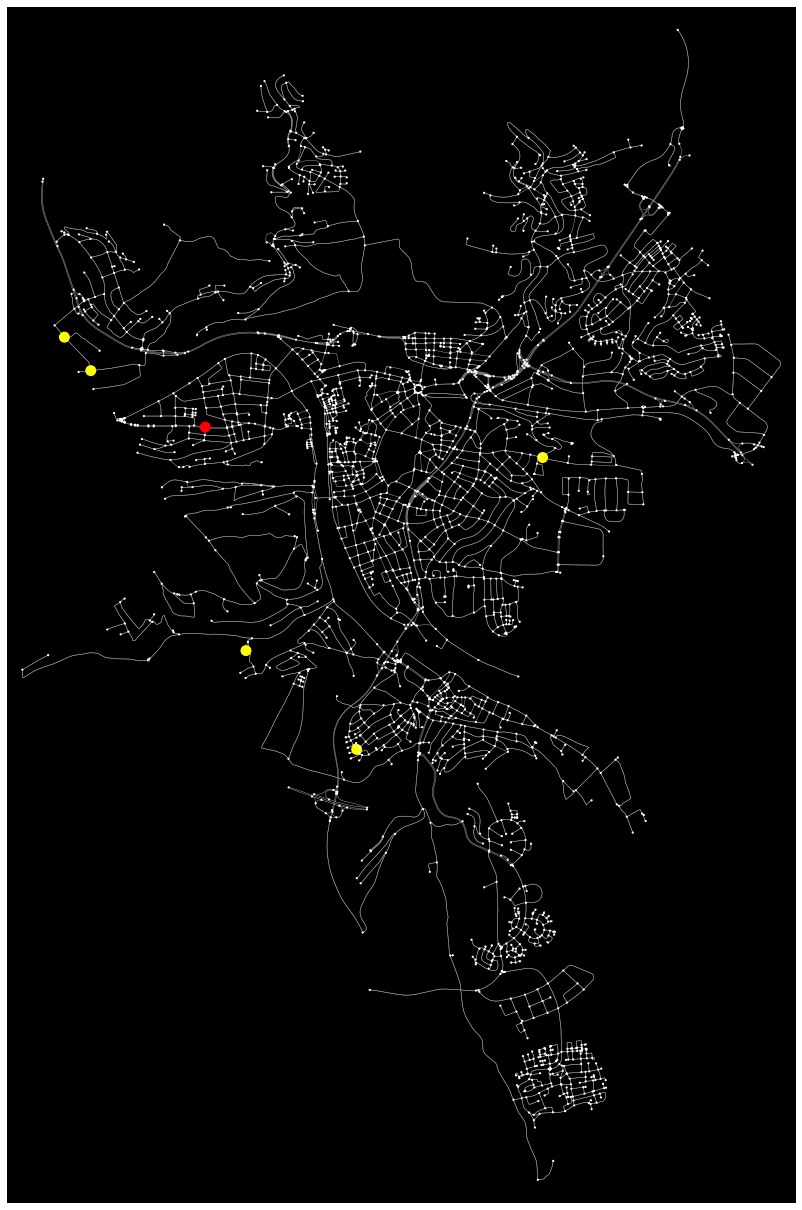

In [66]:
# First show the DC and Customers
warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")
#C3 49.758535, 9.932180
# DC Coords
coord_DC = (49.794783, 9.906499)
# Customer Coords
coord_C1 = (49.78981985, 9.964805881)
coord_C2 = (49.79961774, 9.873297251)
coord_C3 = (49.758535, 9.932180)
coord_C4 = (49.79996773, 9.889586523)
coord_C5 = (49.76905279, 9.913514194)

DC_1 = ox.get_nearest_node(G, coord_DC)
C1 = ox.get_nearest_node(G, coord_C1)
C2 = ox.get_nearest_node(G, coord_C2)
C3 = ox.get_nearest_node(G, coord_C3)
C4 = ox.get_nearest_node(G, coord_C4)
C5 = ox.get_nearest_node(G, coord_C5)

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# Would like Colors of DC and Customers to be different but dont know how to incorporate multiple if statements here
ns = [120 if node == DC_1 or node == C1 or node == C2 or node == C3 or node == C4 or node == C5  else 5 for node in G.nodes()]
#nc = ["red" if node == DC_1 elif (node == C1 or node == C2 or node == C3 or node == C4 or node == C5) "yellow" else "white" for node in G.nodes()]
nc = []
for node in G.nodes():
    if node == DC_1:
        nc.append("red")
    elif (node == C1 or node == C2 or node == C3 or node == C4 or node == C5):
        nc.append("yellow")
    else:
        nc.append("white")
        
#nc = ["white", "red", "red", "red", "red","red"]
#nc = ["red" if node == DC_1 or node == C3  else "white" for node in G.nodes()]
#nc = ["red" if node ==DC_1 or "blue" if node == C1 else "white" for node in G.nodes()] #"yellow", "green", "orange", "purple"]
#nc = ["red" if node == DC_1 or "blue" if node == C1 else "white" for node in G.nodes()]

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

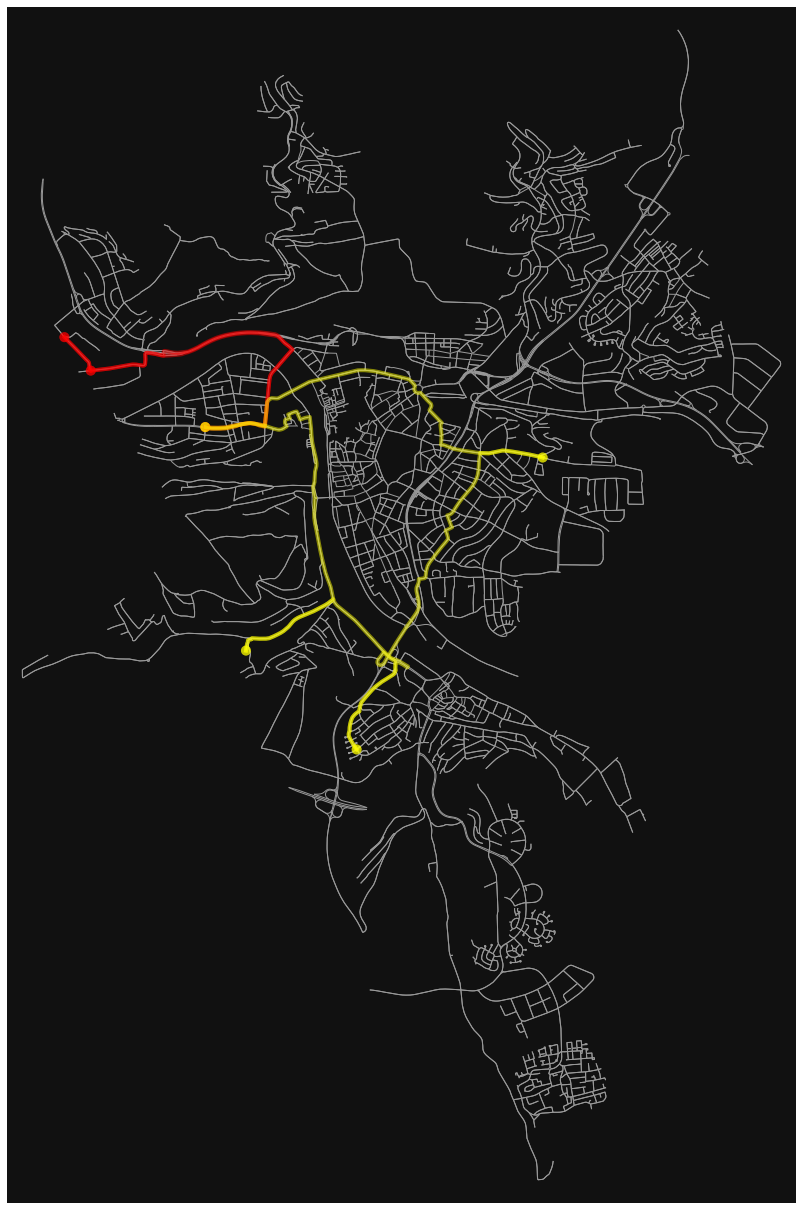

In [58]:
warnings.filterwarnings("ignore")

#Define the place
place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# DC Coords
coord_DC = (49.794783, 9.906499)
# Customer Coords
coord_C1 = (49.78981985, 9.964805881)
coord_C2 = (49.79961774, 9.873297251)
coord_C3 = (49.758535, 9.932180)
coord_C4 = (49.79996773, 9.889586523)
coord_C5 = (49.76905279, 9.913514194)

# Get the nodes from the coords
DC_1 = ox.get_nearest_node(G, coord_DC)
C1 = ox.get_nearest_node(G, coord_C1)
C2 = ox.get_nearest_node(G, coord_C2)
C3 = ox.get_nearest_node(G, coord_C3)
C4 = ox.get_nearest_node(G, coord_C4)
C5 = ox.get_nearest_node(G, coord_C5)

# Routes
# We want Vehicle 2 to drive : DC_1 -> C1 -> C3 -> C5 -> DC_1
V1_Route1 = ox.shortest_path(G, DC_1, C1, weight= "length")
V1_Route2 = ox.shortest_path(G, C1, C3, weight = "length")
V1_Route3 = ox.shortest_path(G, C3, C5, weight= "length")
V1_Route4 = ox.shortest_path(G, C5, DC_1, weight= "length")

# We want Vehicle 1 to drive: DC_1 -> C4 -> C2 -> DC_1
V2_Route1= ox.shortest_path(G, DC_1, C2, weight="length")
V2_Route2= ox.shortest_path(G, C2, C4, weight= "length")
V2_Route3= ox.shortest_path(G, C4, DC_1, weight = "length")
fig, ax = ox.plot_graph_routes(G, 
                               routes =[V2_Route1, V2_Route2, V2_Route3, V1_Route1, V1_Route2, V1_Route3, V1_Route4], route_colors =["red", "red", "red", "yellow", "yellow","yellow","yellow"], # Vehicle 1 Yellows, V2 Red
                               route_linewidth= 4, node_size = 0, figsize=(22,22))

In [59]:
# Get some info about the route lengths and time taken etc. since we used crow flight distances in the Wu_model for now

# Vehicle 1 Distances
V1_Route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route1, "length")))
V1_Route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route2, "length")))
V1_Route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route3, "length")))
V1_Route4_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route4, "length")))
#Vehicle 2 Distances
V2_Route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route1 , "length"))) 
V2_Route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route2 , "length")))
V2_Route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route3 , "length")))

#Vehicle 1 Times
V1_Route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route1, "travel_time")))
V1_Route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route2, "travel_time")))
V1_Route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route3, "travel_time")))
V1_Route4_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V1_Route4, "travel_time")))
#Vehicle 2 Times
V2_Route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route1 , "travel_time"))) 
V2_Route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route2 , "travel_time")))
V2_Route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, V2_Route3 , "travel_time")))

#Printer
#Vehicle 2
print("V2: DC_1 to C2 is", V2_Route1_length, "meters and takes", V2_Route1_time, "seconds.")
print("V2: C2 to C4 is", V2_Route2_length, "meters and takes", V2_Route2_time, "seconds.")
print("V2: C4 to DC_1 is", V2_Route3_length, "meters and takes", V2_Route3_time, "seconds.")
# Vehicle 1
print("V1: DC_1 to C1 is", V1_Route1_length, "meters and takes", V1_Route1_time, "seconds.")
print("V1: C1 to C3 is", V1_Route2_length, "meters and takes", V1_Route2_time, "seconds.")
print("V1: C3 to C5 is", V1_Route3_length, "meters and takes", V1_Route3_time, "seconds.")
print("V1: C5 to DC_1 is", V1_Route4_length, "meters and takes", V1_Route4_time, "seconds.")

V2: DC_1 to C2 is 5157 meters and takes 341 seconds.
V2: C2 to C4 is 539 meters and takes 38 seconds.
V2: C4 to DC_1 is 4529 meters and takes 298 seconds.
V1: DC_1 to C1 is 5195 meters and takes 420 seconds.
V1: C1 to C3 is 5642 meters and takes 523 seconds.
V1: C3 to C5 is 4101 meters and takes 397 seconds.
V1: C5 to DC_1 is 5195 meters and takes 469 seconds.


In [60]:
# Make a Comparison DF for Crow Flight which we got in the dist_mat1 and the actual road distances from osmnx

#Vehicle 1 dist_mat
distances_model1 = []
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and i == ("DC_1") and k == ("V_1"):
        m = dist_mat1.loc[i,j]
        distances_model1.append(m)        
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and k == ("V_1") and i != ("DC_1"):
        n = dist_mat1.loc[i,j]
        distances_model1.append(n)

#Vehicle 2 dist_mat
distances_model2 = []
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and i == ("DC_1") and k == ("V_2"):
        o = dist_mat1.loc[i,j]
        distances_model2.append(o)        
for i,j,k in R:
    if x[i][j][k].varValue >= 0.1 and k == ("V_2") and i != ("DC_1"):
        p = dist_mat1.loc[i,j]
        distances_model2.append(p)
# Vehicle 1 OSMNX
distances_osmnx1 = [V1_Route1_length, V1_Route2_length, V1_Route3_length, V1_Route4_length]
#Vehicle 2 OSMNX
distances_osmnx2 = [V2_Route1_length, V2_Route2_length, V2_Route3_length]

comp_df = pd.DataFrame.from_dict({'Vehicle1_Model':distances_model1,"Vehicle1_osmnx": distances_osmnx1,'Vehicle2_Model':distances_model2,  "Vehicle2_osmnx": distances_osmnx2}, orient='index').T
index = ["Route1", "Route2", "Route3", "Route4"]
comp_df.index = index

# Create column which shows percentage difference between my crow flight approach and the osmnx street distances
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) * 100

comp_df["V1_Diff_Perc"] = percentage_change(comp_df["Vehicle1_Model"], comp_df["Vehicle1_osmnx"]).round(1)
comp_df["V2_Diff_Perc"] = percentage_change(comp_df["Vehicle2_Model"], comp_df["Vehicle2_osmnx"]).round(1)
comp_df = comp_df[["Vehicle1_Model", "Vehicle1_osmnx", "V1_Diff_Perc", "Vehicle2_Model", "Vehicle2_osmnx", "V2_Diff_Perc"]]
comp_df

,Vehicle1_Model,Vehicle1_osmnx,V1_Diff_Perc,Vehicle2_Model,Vehicle2_osmnx,V2_Diff_Perc
Route1,4226.0,5195.0,22.9,2445.0,5157.0,110.9
Route2,5465.0,5642.0,3.2,1171.0,539.0,-54.0
Route3,2092.0,4101.0,96.0,1345.0,4529.0,236.7
Route4,2908.0,5195.0,78.6,NaN,NaN,NaN


<font size="6">**RND TESTING**</font>

In [34]:
Client = [0, 1, 2, 3]
test = [(i, j) for i in Client for j in Client if i != j]
test

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2)]

In [47]:
# helper index for constraint 3
qq = [(i,j) for i in J for j in J if i != j]

qq2 = [(i,j) for i in I for j in J]

qq3 = [(j,i) for j in J for i in I if i!=j]

qq+= qq2
qq += qq3
qq

[('C1', 'C2'),
 ('C1', 'C3'),
 ('C1', 'C4'),
 ('C1', 'C5'),
 ('C2', 'C1'),
 ('C2', 'C3'),
 ('C2', 'C4'),
 ('C2', 'C5'),
 ('C3', 'C1'),
 ('C3', 'C2'),
 ('C3', 'C4'),
 ('C3', 'C5'),
 ('C4', 'C1'),
 ('C4', 'C2'),
 ('C4', 'C3'),
 ('C4', 'C5'),
 ('C5', 'C1'),
 ('C5', 'C2'),
 ('C5', 'C3'),
 ('C5', 'C4'),
 ('DC_1', 'C1'),
 ('DC_1', 'C2'),
 ('DC_1', 'C3'),
 ('DC_1', 'C4'),
 ('DC_1', 'C5'),
 ('C1', 'DC_1'),
 ('C2', 'DC_1'),
 ('C3', 'DC_1'),
 ('C4', 'DC_1'),
 ('C5', 'DC_1')]

In [ ]:
# helper index for constraint 5, not sure if this is correct yet
#qq = [(i,j) for i in J for j in J if i != j]

qq2 = [(i,j) for i in I for j in J]

qq3 = [(j,i) for j in J for i in I if i!=j]

#qq+= qq2
#qq += qq3
qq2 += qq3

qq2

In [ ]:
# Same DF created but without the vehicles, should be obsolete (was first test)

Routes = [(i,j) for i in J for j in J if i != j]
Routes
Routes2 = [(i,j) for i in I for j in J if i!=j]
Routes2
Routes+= Routes2
Routes

df2 = pd.DataFrame(Routes, columns = ["start", "end"])
df2.set_index(["start","end"], inplace=True)
df2.head()

distances_routes = [6665.6,5465.2, 5522.0, 4351.8,
                    6665.6, 6372.1,	1171.1,	4464.5,
                    5465.2,	6372.1, 5890.1,	2092.6,
                    5522.0,	1171.1,	5890.1, 3847.2,
                    4351.8,	4464.5,	2092.6,	3847.2,
                    4226.4,	2445.7,	5000.7,	1345.3,	2908.3]
df2["Distance"] = distances_routes
Routes_df = df2
Routes_df.head()

In [79]:
asd = {"C1","C2","C3","C4","C5"}
das = {"DC_1"}

In [80]:
res = asd.union(das)
res

{'C1', 'C2', 'C3', 'C4', 'C5', 'DC_1'}

In [84]:
# helper index for U ? not sure if it should have customer to customer and then vehicle or just customer/vehicle
help_u = [(l,k) for l in J for k in K]
U = help_u
U

[('C1', 'V_1'),
 ('C1', 'V_2'),
 ('C2', 'V_1'),
 ('C2', 'V_2'),
 ('C3', 'V_1'),
 ('C3', 'V_2'),
 ('C4', 'V_1'),
 ('C4', 'V_2'),
 ('C5', 'V_1'),
 ('C5', 'V_2')]

In [88]:
# new helper index for constraint 4!
UU = [(l,j) for l in J for j in J if l!=j]
UU

[('C1', 'C2'),
 ('C1', 'C3'),
 ('C1', 'C4'),
 ('C1', 'C5'),
 ('C2', 'C1'),
 ('C2', 'C3'),
 ('C2', 'C4'),
 ('C2', 'C5'),
 ('C3', 'C1'),
 ('C3', 'C2'),
 ('C3', 'C4'),
 ('C3', 'C5'),
 ('C4', 'C1'),
 ('C4', 'C2'),
 ('C4', 'C3'),
 ('C4', 'C5'),
 ('C5', 'C1'),
 ('C5', 'C2'),
 ('C5', 'C3'),
 ('C5', 'C4')]

In [160]:
# Trying to store my output in a list and then parse it with regex to get a nicer looking solution printer
result = []
for variable in model.variables():
    if variable.varValue >= 0.1:
        o = [variable.name, variable.varValue]
        result.append(o)
result

[["u_('C2',_'V_1')", 1.0],
 ["u_('C2',_'V_2')", 4.0],
 ["u_('C3',_'V_2')", 1.0],
 ["u_('C5',_'V_2')", 4.0],
 ['x_C1_C3_V_2', 1],
 ['x_C2_DC_1_V_1', 1],
 ['x_C3_C5_V_2', 1],
 ['x_C4_C2_V_1', 1],
 ['x_C5_DC_1_V_2', 1],
 ['x_DC_1_C1_V_2', 1],
 ['x_DC_1_C4_V_1', 1],
 ['y_DC_1', 1],
 ['z_DC_1_C2', 1],
 ['z_DC_1_C3', 1],
 ['z_DC_1_C5', 1]]

<font size="6">**Old Constraints**</font>

Save some of the old constraints here in case they are needed again and I made a mistake (these are pre-formchange of decision variables)

In [ ]:
#helper list for constraints including I union J
qa = [(j) for j in J]
qd = [(i) for i in I]
qa += qd
qa

In [ ]:
# (2) worked
for j in J:
    model += lpSum([x[i,j,k] for i in qa if i!=j for k in K]) == 1

# Constraint (3)
# this seems to be correct, has all the connections from customers to customers
# added a for j in J into the second term (not sure if thats right, but it added the missing connections)
for k in K:
    model += lpSum(set_of_all_customers.loc[j].demand_C for j in J) * lpSum([x[i,j,k] for i in qa for j in J if i!=j]) <= set_of_all_vehicles.loc[k].capacity_V

# (4) - same exact constraint but without the helper list
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                model += (u[l,k] - u[j,k] + (len(set_of_all_customers) * x[l,j,k])) <= len(set_of_all_customers) - 1  

# (5) worked: the if statement seems to have fixed the problem of routing from the same node to the same node which cause an error
for i in qa:
    for k in K:
        model += lpSum([x[i,j,k] for j in qa if i!=j]) - lpSum([x[j,i,k] for j in qa if i!=j]) == 0

# (6) should be fine: Worked
for k in K:
    model += lpSum([x[i,j,k] for i in I for j in J]) <= 1

# (7) should be fine : Worked 
for i in I:
    model += lpSum([z[i,j] * set_of_all_customers.loc[j].demand_C for j in J] - (set_of_all_DC.loc[i].capacity_DC * y[i])) <= 

# (8) Worked - two if statements seem to have eliminated the single node routing (from C1 to C1) etc. - used helper constraint qa again from constraint 5
for i in I:
    for j in J:
        for k in K:
            model += -z[i,j] + lpSum((x[i,u,k] + x[u,j,k] for u in qa if u!=i if u!=j)) <= 1